In [10]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [12]:
import bnn.data
import bnn.functions
import bnn.layer
import bnn.loss
import bnn.network
import bnn.optimizer

In [13]:
forward_func = bnn.functions.forward.SignBinarise()
#forward_func=bnn.functions.forward.LayerMeanBinarise()
#forward_func=bnn.functions.forward.LayerMedianBinarise()

In [14]:
backward_func = bnn.functions.backward.SignTernarise()
#backward_func = bnn.functions.backward.LayerMeanStdTernarise(half_range_stds=0.5)
#backward_func = bnn.functions.backward.LayerQuantileTernarise(lo=0.25, hi=0.75)

In [15]:
dims = [1, 100, 100, 4]
TBNN = bnn.network.TernBinNetwork(
    *dims,
    forward_func=forward_func,
    backward_func=backward_func,
)

In [16]:
TBNN._initialise(W_mean=0, W_zero_prob=0.5)

In [17]:
samples = 100
input = bnn.functions.binarise(torch.randn(samples, 1).to(torch.int))
desired = torch.stack(
    [input[..., 0], -input[..., 0], torch.ones(samples, dtype=torch.int), -torch.ones(samples, dtype=torch.int)], dim=-1
)
desired.shape

torch.Size([100, 4])

In [18]:
loss_func: bnn.loss.LossFunction = bnn.loss.l1

In [19]:
BernOpt = bnn.optimizer.ExpectationSGD(TBNN.parameters(), lr=0.001)

In [20]:
losses = []

In [21]:
initial_train_epochs = 50

In [22]:
for epoch in range(initial_train_epochs):
    # forward pass
    output = TBNN.forward(input)
    loss = loss_func.forward(output=output, target=desired)
    losses.append(loss)

    # backward pass
    grad = loss_func.backward(output=output, target=desired)
    out_grad = TBNN.backward(grad)

    # optimizer step
    BernOpt.step(number_of_samples=len(input))

    early_exit = loss == 0

    if early_exit or (epoch % 10) == 0:
        print(f'epoch: {epoch}\tloss: {loss}')

    if early_exit:
        break

epoch: 0	loss: 236
epoch: 4	loss: 0


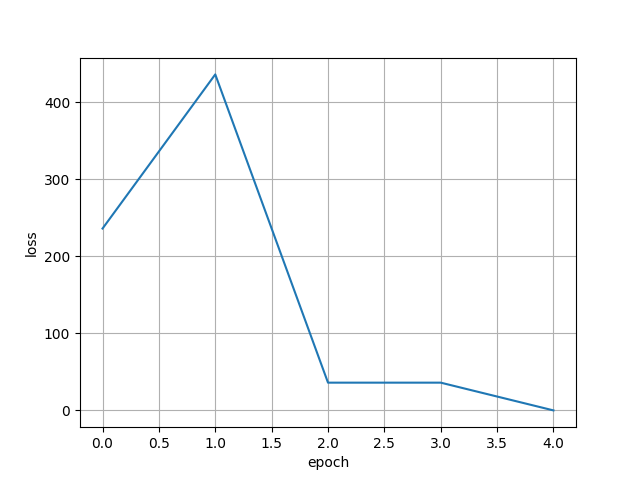

In [23]:
NAME = 'loss_curve_partial'
plt.close(NAME)
plt.figure(NAME)

plt.plot(losses[:initial_train_epochs])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.show()

In [24]:
for name, p in TBNN.named_parameters():
    if name.lower().endswith('.w'):
        print(name, '\n', p, '\n', p.grad)

layers.TernBinLayer0.W 
 Parameter containing:
tensor([[-1,  0,  0,  0, -1,  1,  0,  0,  0,  1,  1, -1,  0, -1,  0, -1,  0, -1,
          0, -1,  1,  1,  0,  0,  0,  1,  0, -1,  1,  0,  1,  0,  1,  0,  0,  0,
          1, -1,  0,  0,  1,  0,  1,  1,  0,  0,  0, -1,  0,  1,  1,  0,  1,  1,
          1,  0,  0,  1, -1,  0,  1,  0,  0,  1,  1,  0, -1, -1,  0,  0, -1,  0,
         -1, -1, -1, -1,  0, -1,  1,  0,  0,  0, -1, -1, -1, -1,  1,  0, -1,  1,
          0, -1, -1,  0,  0, -1,  0, -1, -1, -1]], dtype=torch.int32) 
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]], dtype=torch.int32)
layers.TernBinLayer1.W 
 Parameter containing:
tensor([[-1,  0, -1,  ...,  0,  0,  0],
        [ 0,  0, -1,  .

In [41]:
assert bnn.network.network_params_al_ternary(TBNN)

In [61]:
DL = bnn.data.TargetNetwork(
    datapoints=20,
    batch_size=5,
    target_network=TBNN,
    include_last_if_uneven=True,
)

In [62]:
len(DL)

20

In [63]:
for i, d in enumerate(DL):
    print(i)
    print(d.input)
    print(d.target)

0
tensor([[-1],
        [ 1],
        [-1],
        [-1],
        [-1]], dtype=torch.int32)
tensor([[-1,  1,  1, -1],
        [ 1, -1,  1, -1],
        [-1,  1,  1, -1],
        [-1,  1,  1, -1],
        [-1,  1,  1, -1]], dtype=torch.int32)
1
tensor([[ 1],
        [-1],
        [ 1],
        [ 1],
        [ 1]], dtype=torch.int32)
tensor([[ 1, -1,  1, -1],
        [-1,  1,  1, -1],
        [ 1, -1,  1, -1],
        [ 1, -1,  1, -1],
        [ 1, -1,  1, -1]], dtype=torch.int32)
2
tensor([[ 1],
        [-1],
        [-1],
        [-1],
        [-1]], dtype=torch.int32)
tensor([[ 1, -1,  1, -1],
        [-1,  1,  1, -1],
        [-1,  1,  1, -1],
        [-1,  1,  1, -1],
        [-1,  1,  1, -1]], dtype=torch.int32)
3
tensor([[-1],
        [-1],
        [ 1],
        [ 1],
        [ 1]], dtype=torch.int32)
tensor([[-1,  1,  1, -1],
        [-1,  1,  1, -1],
        [ 1, -1,  1, -1],
        [ 1, -1,  1, -1],
        [ 1, -1,  1, -1]], dtype=torch.int32)
